## Layered API 

Using the high-level api: just create the data loaders for me using all your defaults. 

This works well if your data is arranged in a particular way, which it won't always be 

In [2]:
from fastai.text.all import * 

In [3]:
# note how this is caches at .fastai/data if you've already downloaded it 
path = untar_data(URLs.IMDB); path 

Path('/home/mchristos/.fastai/data/imdb')

In [4]:
dls = TextDataLoaders.from_folder(path, valid='test')  

In [5]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love story is an interesting one , however . xxmaj kate xxmaj winslett is wonderful as xxmaj rose , an aristocratic young lady betrothed by xxmaj cal ( billy xxmaj zane ) . xxmaj early on the voyage xxmaj rose meets xxmaj jack ( leonardo dicaprio ) , a lower class artist on his way to xxmaj america after winning his ticket aboard xxmaj titanic in a poker game . xxmaj if he wants something , he goes and gets it",pos
2,"xxbos xxmaj okay , so xxmaj i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games that look exactly the same , with the hand in the bottom on the screen , supposedly your own , holding whatever weapon and goo - ing all kinds of aliens or walking dead or snipers or whatever the case may be . \n\n xxmaj it 's an interesting premise in xxmaj house of the xxmaj dead , with a lot of college kids ( loaded college kids , as it were , kids who are able to pay",neg


The dataloader now contains the transformed datasets for training and validation. Each item in the dataset is a tensor of transformed inputs and outputs

In [6]:
dls.train.dataset[:1], dls.valid.dataset[:1]

([(TensorText([    2,     8,    80,    19,   624,   159,   107,    14,    45,
                  11,    21,    19,   469,    52,  2322,    60,    20,    30,
                  21,    19,  5418,    73,    15,   941,  3961,    15,   739,
                  17,    10,     8,    12,    79,   739,    67,     8,    20,
                  16,   738,     9,   271,    30,    19,    42,   145,   132,
                  10,    26,     8,     9,  4174,    14,     9,    30,  2853,
               54200,     8,  3597,    11,  8361,    11,    77,  1953,    11,
                 543,    10,    11,    31,     9,   119,   131,  1226,    15,
                2849,   733,    45,   152,   781,   311,    10,     8,   419,
                   9,   441,    14,     8,  1249,     8,  1260,    21,  2402,
                   0,   519,     8,   255,     8,   230,   801,    64,   342,
                4295,    64,    67,     8,    89,   152,     0,   105,   947,
                   8, 18144,    67,     8,   115,    53,     9, 

In [7]:
TextDataLoaders.from_folder??

Signature:
TextDataLoaders.from_folder(
    path,
    train='train',
    valid='valid',
    valid_pct=None,
    seed=None,
    vocab=None,
    text_vocab=None,
    is_lm=False,
    tok_tfm=None,
    seq_len=72,
    splitter=None,
    backwards=False,
    *,
    bs: 'int' = 64,
    val_bs: 'int' = None,
    shuffle: 'bool' = True,
    device=None,
)
Source:   
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, text_vocab=None, is_lm=False,
                    tok_tfm=None, seq_len=72, splitter=None, backwards=False, **kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        if splitter is None:
            splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        blocks = [TextBlock.from_folder(path, text_vocab, is_lm, seq_len, b

We used: 
- default tokenizing of text 
- default label is the parent directory of a given file

We can get the same results by using the data block API more explicitly: 

In [8]:
dls = DataBlock(
    # how to transform features and labels. text -> tokens -> numbers. label -> integer     
    blocks=(TextBlock.from_folder(path), CategoryBlock),
    # how to get a label from the input file path     
    get_y=parent_label,
    # how to get the input data from an input path (find any text files under the train or test dirs) 
    get_items=partial(get_text_files, folders=['train','test']),
    # how to split the data between training and validation sets     
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

Blocks are there essentially to encode a transformation or set of transformations on your raw input data. e.g. for text, we need to tokenize the whole corpus, get the vocab size, map each token to a number etc. 

## Transforms  

How does fastai figure out how to get back to the original text from the transformed data? Each transform has an "encode" and "decode" method.  

In [9]:
files = get_text_files(path, folders=['test','train']) 
txts = L(f.open().read() for f in files[:2000])
txts[0]

"What could have been an excellent hostage movie was totally ruined by what apparently looks like a bored director ... there were so many directions that the movie could have taken ... a vampire slash-fest was not one of these!!! The last 45 mins. or so results in the movie being an absolutely ridiculous waste of time. ...and sex machine?? ... you gotta be kidding me! The acting talents of the likes of Juliette Lewis and Harvey Keitel (not to mention George Clooney) are completely wasted in this nonsensical movie. <br /><br />The director... Robert Rodriguez, known for his other gory flicks including el mariachi, desperado, once upon a time in Mexico, and the very recent sin city ... really holds your attention with the well executed first half ... which leads you to believe that you are in for an entertaining time ... but then apparently for no reason, and without any provocation, the madness starts ... there's even feeble attempts at parody and comedy ... truly exasperating!!"

In [10]:
# from_folder actually goes through the folder and tokenizes each text file that it finds, 
# storing the results in ~/.fastai/data/imdb_tok in this case
tok = Tokenizer.from_folder(path) 

In [11]:
tok.output_dir

Path('/home/mchristos/.fastai/data/imdb_tok')

In [12]:
tok.setup(txts) 

In [13]:
toks = txts.map(tok) 
toks[0]

(#207) ['xxbos','xxmaj','what','could','have','been','an','excellent','hostage','movie'...]

In [14]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num) 
nums[0]

TensorText([   2,    8,   62,   85,   38,   97,   56,  684, 2965,   27,   24,
             366, 1459,   51,   62,  500,  266,   49,   12,  980,  173,   73,
              54,   77,   47,  139, 4488,   21,    9,   27,   85,   38,  590,
              73,   12, 1033, 7891,   25, 1853,   24,   37,   42,   14,  151,
               5,  141,   55,    8,    9,  257, 2966, 5004,   10,   57,   47,
            2176,   19,    9,   27,  134,   56,  442,  453,  247,   14,   82,
              10,   73,   13,  382, 1363,   50,   50,   73,   34,  196, 2487,
              40, 2083,   87,   55,    8,    9,  111, 1777,   14,    9, 1460,
              14,    8, 5678,    8, 1271,   13,    8, 4053,    8, 3172,   39,
              37,   15,  555,    8,  853,    8, 4054,   36,   41,  324,  528,
              19,   20, 2639,   27,   10,   26,    8,    9,  173,   73,    8,
             608,    8, 4489,   11,  685,   28,   45,  107, 2177, 1364,  756,
            2967, 6577,   11,    0,   11,  312,  652,   12,   82

In [15]:
decoded = num.decode(nums[0]); decoded

(#207) ['xxbos','xxmaj','what','could','have','been','an','excellent','hostage','movie'...]

In [16]:
tok.decode(decoded) 

"xxbos xxmaj what could have been an excellent hostage movie was totally ruined by what apparently looks like a bored director … there were so many directions that the movie could have taken … a vampire slash - fest was not one of these xxrep 3 ! xxmaj the last 45 mins . or so results in the movie being an absolutely ridiculous waste of time . … and sex machine ? ? … you got ta be kidding me ! xxmaj the acting talents of the likes of xxmaj juliette xxmaj lewis and xxmaj harvey xxmaj keitel ( not to mention xxmaj george xxmaj clooney ) are completely wasted in this nonsensical movie . \n\n xxmaj the director … xxmaj robert xxmaj rodriguez , known for his other gory flicks including el mariachi , xxunk , once upon a time in xxmaj mexico , and the very recent sin city … really holds your attention with the well executed first half … which leads you to believe that you are in for an entertaining time … but then apparently for no reason , and without any xxunk , the madness starts … there '

tok and num are both examples of Transform classes, which all have a decode and encode method 

## Writing Your Own Transform 

In [17]:
def f(x:int): return x + 1
tfm = Transform(f)
tfm(2), tfm(2.) 

(3, 2.0)

In [18]:
@Transform
def tfm(x:int): return x + 1
tfm(2), tfm(2.) 

(3, 2.0)

In [19]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self,x): return x - self.mean
    def decodes(self,x): return x + self.mean

In [20]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y) 
tfm.mean,y,z

(3.0, -1.0, 2.0)

## Pipeline  

Use Pipeline to put together a set of Transforms 

In [21]:
tfms = Pipeline((tok,num))

In [22]:
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,   62,   85,   38,   97,   56,  684, 2965,   27,   24,
             366, 1459,   51,   62,  500,  266,   49,   12,  980])

In [23]:
tfms.decode(t)

"xxbos xxmaj what could have been an excellent hostage movie was totally ruined by what apparently looks like a bored director … there were so many directions that the movie could have taken … a vampire slash - fest was not one of these xxrep 3 ! xxmaj the last 45 mins . or so results in the movie being an absolutely ridiculous waste of time . … and sex machine ? ? … you got ta be kidding me ! xxmaj the acting talents of the likes of xxmaj juliette xxmaj lewis and xxmaj harvey xxmaj keitel ( not to mention xxmaj george xxmaj clooney ) are completely wasted in this nonsensical movie . \n\n xxmaj the director … xxmaj robert xxmaj rodriguez , known for his other gory flicks including el mariachi , xxunk , once upon a time in xxmaj mexico , and the very recent sin city … really holds your attention with the well executed first half … which leads you to believe that you are in for an entertaining time … but then apparently for no reason , and without any xxunk , the madness starts … there '

In [24]:
tok.decode(num.decode(t)) 

"xxbos xxmaj what could have been an excellent hostage movie was totally ruined by what apparently looks like a bored director … there were so many directions that the movie could have taken … a vampire slash - fest was not one of these xxrep 3 ! xxmaj the last 45 mins . or so results in the movie being an absolutely ridiculous waste of time . … and sex machine ? ? … you got ta be kidding me ! xxmaj the acting talents of the likes of xxmaj juliette xxmaj lewis and xxmaj harvey xxmaj keitel ( not to mention xxmaj george xxmaj clooney ) are completely wasted in this nonsensical movie . \n\n xxmaj the director … xxmaj robert xxmaj rodriguez , known for his other gory flicks including el mariachi , xxunk , once upon a time in xxmaj mexico , and the very recent sin city … really holds your attention with the well executed first half … which leads you to believe that you are in for an entertaining time … but then apparently for no reason , and without any xxunk , the madness starts … there '

In [26]:
num.decode([1,2,3,4,1000, 1001,1002,2001,3001])

(#9) ['xxpad','xxbos','xxeos','xxfld','whom','holes','oscar','radio','paint']

## TfmdLists and Datasets

We need a way to connect our raw data (files or some dataframe) with the transformed data via encode and decode methods. 

TfmdLists stores the transformed data, as well as exposing a decode method to get back to where you started, for debugging reasons 

In [27]:
files[:1]

(#1) [Path('/home/mchristos/.fastai/data/imdb/test/neg/12193_3.txt')]

### transforming the X inputs 

In [28]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

I'm now wondering how the first transform, namely the tokenizer returned by Tokenizer.from_folder, knows how to operate on a list of file paths

In [29]:
tls[0][:20]

TensorText([   2,    8,   65,   96,   42,   99,   49,  346, 4647,   30,   25,
             483, 2413,   48,   65,  684,  309,   53,   13, 1086])

In [30]:
tls.decode(tls[1])

'xxbos xxmaj one of the problems with popular culture , especially when discussing the popular culture of the 1970s , is that mass media - especially television - is usually about four years behind \' underground \' media , primarily music . xxmaj many people think the \' woodstock xxmaj generation " remained important throughout the 1970s ; actually , it was all over at xxmaj altamont in 1970 . xxmaj by 1972 , \' underground \' rock or the \' counterculture \' had moved east to xxmaj england and xxmaj led xxmaj xxunk , xxmaj black sabbath , and xxmaj david xxmaj bowie , early metal - heads and the so - called \' glam - rockers , \' who were all \' peace and love \' - not . xxmaj neither , in a darkly different vein , was xxmaj charles xxmaj manson \'s \' family . \' \n\n xxmaj this obvious pilot for a television show ( that , thankfully , was never picked up by the networks ) is attempting to come to terms with a culture that was already as withered as yesterday \'s flowers . xxmaj th

using show() rather than the decode method just makes it a bit prettier 

In [31]:
tls.show(tls[1])

xxbos xxmaj one of the problems with popular culture , especially when discussing the popular culture of the 1970s , is that mass media - especially television - is usually about four years behind ' underground ' media , primarily music . xxmaj many people think the ' woodstock xxmaj generation " remained important throughout the 1970s ; actually , it was all over at xxmaj altamont in 1970 . xxmaj by 1972 , ' underground ' rock or the ' counterculture ' had moved east to xxmaj england and xxmaj led xxmaj xxunk , xxmaj black sabbath , and xxmaj david xxmaj bowie , early metal - heads and the so - called ' glam - rockers , ' who were all ' peace and love ' - not . xxmaj neither , in a darkly different vein , was xxmaj charles xxmaj manson 's ' family . ' 

 xxmaj this obvious pilot for a television show ( that , thankfully , was never picked up by the networks ) is attempting to come to terms with a culture that was already as withered as yesterday 's flowers . xxmaj the script must have

It can also store the train and test data in separate attributes, hence the plural 's' in the name. By default all the data is shoved into the test attribute 

In [32]:
tls.train[0]

TensorText([    2,     8,    65,    96,    42,    99,    49,   346,  4647,
               30,    25,   483,  2413,    48,    65,   684,   309,    53,
               13,  1086,   172,    76,    55,    88,    52,   130,  5538,
               21,     9,    30,    96,    42,   597,    76,    13,  1282,
             8728,    24,  3101,    25,    38,    44,    14,   152,     5,
              153,    54,     8,     9,   251,  3636,  5759,    10,    56,
               52,  1956,    18,     9,    30,   129,    49,   450,   662,
              475,    14,    77,    10,    76,    12,   373,  1592,    67,
               67,    76,    33,   208,  3135,    43,  3937,    90,    54,
                8,     9,   138,  2021,    14,     9,  1201,    14,     8,
             6385,     8,  1726,    12,     8,  4096,     8,  6811,    37,
               38,    15,   760,     8,   742,     8,  6497,    34,    39,
              357,  1023,    18,    20,  5154,    30,    10,    26,     8,
                9,   172,

In [33]:
cut = int(len(files)*0.8); cut
splits = [list(range(cut)), list(range(cut, len(files)))]; splits
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], splits=splits)

In [34]:
tls.valid[0][:20]

TensorText([  2,  19, 527,  20,  32,  11, 401, 108,  19,  87,  38, 132, 121,
            851,  11, 543,  10,   8,  17,  25])

### transforming the y labels 

In [35]:
labels = files.map(parent_label); labels

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

In [36]:
cat = Categorize()
cat.setup(labels)
cat.vocab, cat(labels[0])

(['neg', 'pos'], TensorCategory(0))

In [37]:
# Note that transforms apply across tuples naturally
cat(('pos','pos','neg'))

(TensorCategory(1), TensorCategory(1), TensorCategory(0))

In [38]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

## Datasets 

This class helps us stitch together our two things we now have: trasformed input data (text -> numbers) and transformed label data (also text -> numbers but to two integer labels or categories in this case). 

Datasets will apply a set of pipelines to two (or more) raw datasets in parallel - thus building the transformed inputs and transformed labels, and keeping them tupled together - whilst remembering how to decode them too.  

In [39]:
x_tfms = [Tokenizer.from_folder(path), Numericalize] 
y_tfms = [parent_label, Categorize()] 

In [40]:
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits) 

To me, this is so much simpler than the DataBlock API, where I find it hard to imagine and remember what tranformations are happening and where. 

In [41]:
x, y = dsets.valid[0]
x[:20],y

(TensorText([  2,  19, 527,  20,  32,  11, 401, 108,  19,  87,  38, 132, 121,
             851,  11, 543,  10,   8,  17,  25]),
 TensorCategory(1))

In [42]:
t = dsets.valid[0]
dsets.decode(t)

('xxbos i enjoyed this film , perhaps because i had not seen any reviews , etc . xxmaj it was delightful and a little bit of a \' romp \' . i do n\'t know why it did n\'t make more of a splash than it did . xxmaj as far as the story goes , i could relate to some aspects of the xxmaj paul xxmaj reiser character , and i could " see my dad " in xxmaj falk \'s character . xxmaj made me remember a lot of past times when i was a kid and listening to my grandparents , too . xxmaj if you enjoyed movies like xxmaj grumpy xxmaj old xxmaj men or xxmaj on xxmaj golden xxmaj pond , this is your movie . a " sleeper " , in my opinion , and one of those feel - good stories . xxmaj peter xxmaj falk and xxmaj paul xxmaj reiser had many wonderful verbal tussles , yet nothing was overdone . i would say it rates at least an 8 , perhaps higher .',
 'pos')

In [43]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input); dls.valid.show_batch(max_n=2)

,text,category
0,"xxbos i enjoyed this film , perhaps because i had not seen any reviews , etc . xxmaj it was delightful and a little bit of a ' romp ' . i do n't know why it did n't make more of a splash than it did . xxmaj as far as the story goes , i could relate to some aspects of the xxmaj paul xxmaj reiser character , and i could "" see my dad "" in xxmaj falk 's character . xxmaj made me remember a lot of past times when i was a kid and listening to my grandparents , too . xxmaj if you enjoyed movies like xxmaj grumpy xxmaj old xxmaj men or xxmaj on xxmaj golden xxmaj pond , this is your movie . a "" sleeper "" , in my opinion , and one of those feel - good stories . xxmaj",pos
1,xxbos xxmaj xxunk ( which reads xxmaj starstruck on my box ) was the most amazing movie i have ever seen . i thought that it was one of the best movies i have ever seen . xxmaj so why not a 10 ? xxmaj nothing is perfect . xxmaj jamie xxmaj kennedy proves why he is one of my favorite actors in this very interesting look at a darker side of xxmaj hollywood . i have forced a few others to watch the movie and they all agreed that it was an outstanding flick . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,pos


### here it all is in 5 lines!

In [44]:
# how to get the x and y values, and transform them 
x_tfms, y_tfms = [Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize()]
# how to get the source data for the transforms to work on 
files = get_text_files(path, folders=['train','test'])
# how to split between test and valid 
splits = GrandparentSplitter(valid_name='test')(files)
# let Datasets do the work of applying all the transforms and splits and remembering them 
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
# how to load data into batches 
dls = dsets.dataloaders(dl_type=SortedDL,before_batch=pad_input)

In [45]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj jim xxmaj carrey is back to much the same role that he played in xxmaj the xxmaj mask , a timid guy who is trying to get ahead in the world but who seems to be plagued with bad luck . xxmaj even when he tries to help a homeless guy from being harassed by a bunch of hoodlums ( and of course they have to be xxmaj mexican , obviously ) , his good will towards his fellow man backfires . xxmaj in that case , it was n't too hard to predict that he was about to have a handful of angry hoodlums , but i like that the movie suggests that things like that should n't be ignored . xxmaj i 'm reminded of the episode of xxmaj michael xxmaj moore 's brilliant xxmaj the xxmaj awful xxmaj truth , when they had a man",pos
2,"xxbos xxrep 3 * xxup spoilers xxrep 3 * xxrep 3 * xxup spoilers xxrep 3 * xxmaj continued … \n\n xxmaj from here on in the whole movie collapses in on itself . xxmaj first we meet a rogue program with the indication we 're gon na get ghosts and vampires and werewolves and the like . xxmaj we get a guy with a retarded accent talking endless garbage , two ' ghosts ' that serve no real purpose and have no character what - so - ever and a bunch of henchmen . xxmaj someone 's told me they 're vampires ( straight out of xxmaj blade 2 ) , but they 're so undefined i did n't realise . \n\n xxmaj the funny accented guy with a ridiculous name suffers the same problem as the xxmaj oracle , only for far longer and far far worse .",neg


## Applying the Mid-Level Data API 

In [46]:
from fastai.vision.all import * 

In [47]:
path = untar_data(URLs.PETS); path

Path('/home/mchristos/.fastai/data/oxford-iiit-pet')

In [48]:
files = get_image_files(path/'images'); files[:3]

(#3) [Path('/home/mchristos/.fastai/data/oxford-iiit-pet/images/Birman_115.jpg'),Path('/home/mchristos/.fastai/data/oxford-iiit-pet/images/leonberger_142.jpg'),Path('/home/mchristos/.fastai/data/oxford-iiit-pet/images/Bombay_68.jpg')]

In [49]:
x = fastuple(2,3,4); type(x)

fastcore.basics.fastuple

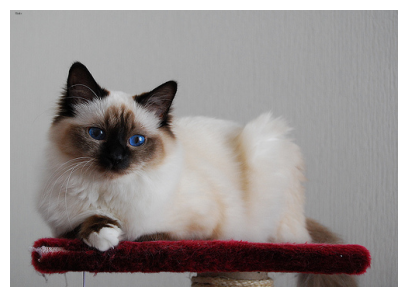

In [50]:
im0 = PILImage.create(files[0])
show_image(im0);

In [51]:
# Since transforms naturally apply across tuples, all we need to do here is inherit from the tuple class 
# and implement a show method for display purposes 
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2=img1,img2        
        line = t1.new_zeros(t1.shape[0], t1.shape[1],10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=same_breed,ctx=ctx)

In [52]:
isinstance(im0, Tensor)

False

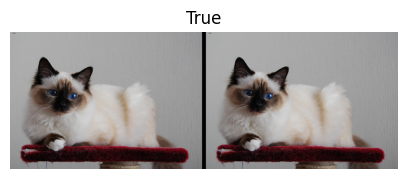

In [53]:
s = SiameseImage(im0,im0,True)
s.show();

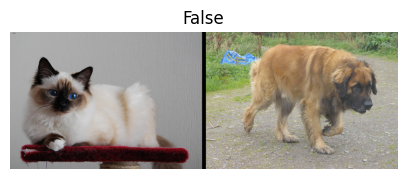

In [54]:
im1 = PILImage.create(files[1])
s1 = SiameseImage(im0,im1,False)
s1.show();

Transforms apply over all elements in tuples - that's wy we subclassed from tuple here. Now we can apply transformations to these stitched-together images! 

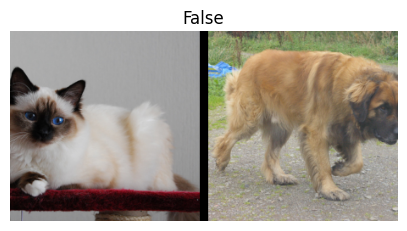

In [55]:
resized = Resize(224)(s1)
resized.show();

Resize is applied to the images, but not the boolean, because transforms are smart like that - they apply to every item in the tuple, as long as the value is of a type that can be transformed. 

Now we can define a custom function which will get the correct label for us. It should be true if the animals have the same breed, and false if not. It just gets the text before the underscore and digit, which in the filename is always the breed of animal 

In [56]:
def label_func(filename):
    return re.match(r'^(.*)_\d+.jpg', filename.name).groups()[0]

In [57]:
files.map(label_func)[:20]

(#20) ['Birman','leonberger','Bombay','japanese_chin','saint_bernard','Ragdoll','japanese_chin','Ragdoll','Persian','scottish_terrier'...]

In [58]:
import random 
# Define a custom transform for building the pairs of images 
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        # get all the unique labels in the files 
        self.labels = files.map(label_func).unique()
        # map each label back to its set of files (e.g. all american bulldog file paths) 
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        # draw each of the validation pairs in advance 
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
    
    def encodes(self,f):
        # take the pair from the pre-computed validation values if exists, else default to drawing again 
        # (i.e. for training samples)          
        f2, same = self.valid.get(f, self._draw(f))
        im1,im2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(im1,im2,same)
    
    def _draw(self,f):
        """
        randomly choose a siamese pair for f
        with P(0.5) choose a random file of the same breed
        with P(0.5) choose a random file of different breed
        """
        same = random.random() < 0.5
        cls = self.label_func(f) 
        if not same:
            # find a random different breed class
            cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]), same        

In [59]:
RandomSplitter??

Signature: RandomSplitter(valid_pct=0.2, seed=None)
Source:   
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(list(torch.randperm(len(o)).numpy()))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
File:      ~/code/fastbook/venv/lib/python3.8/site-packages/fastai/data/transforms.py
Type:      function


In [60]:
splits = RandomSplitter()(files) 
splits

((#5912) [1093,2407,1770,4814,965,2177,6543,2812,6090,3151...],
 (#1478) [4812,3182,3228,1734,7276,5570,5818,5780,6785,329...])

In [61]:
tfm = SiameseTransform(files, label_func,splits)

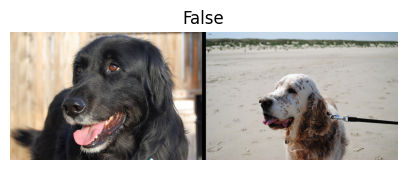

In [62]:
img = tfm(files[2582])
img.show();

In [63]:
tls = TfmdLists(files, tfm, splits=splits) 

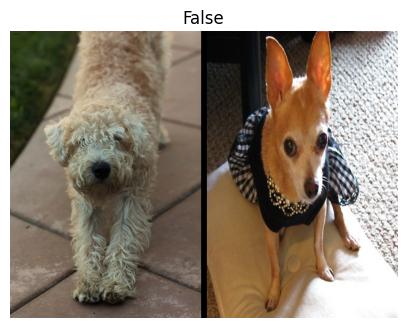

In [64]:
tls.valid[0].show();

In [65]:
dls = tls.dataloaders(after_item=[Resize(224),ToTensor], after_batch=[IntToFloatTensor,Normalize.from_stats(*imagenet_stats)])

In [66]:
ds = dls.valid.dataset

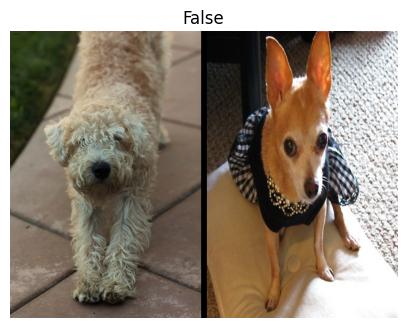

In [67]:
ds[0].show();